# Fire detection

In [35]:
from utils import *
from skimage import data, util
from skimage.color import rgb2lab, lab2lch,rgba2rgb
import numpy as np
import math
import skimage.io as io
from matplotlib.ticker import LinearLocator
import cv2

## Fast and Efficient Method for Fire Detection Using Image Processing

### Pseudocódigo

The motivation for using CIE Lab* color space is because it is perceptually uniform color space

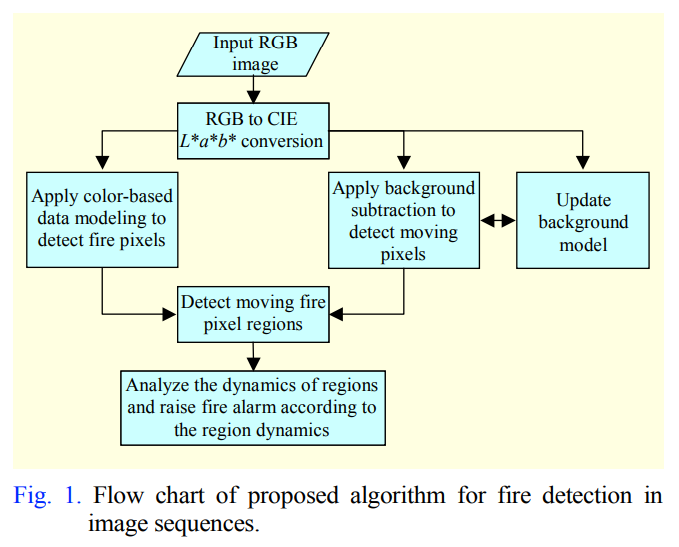

### Cie-Lab
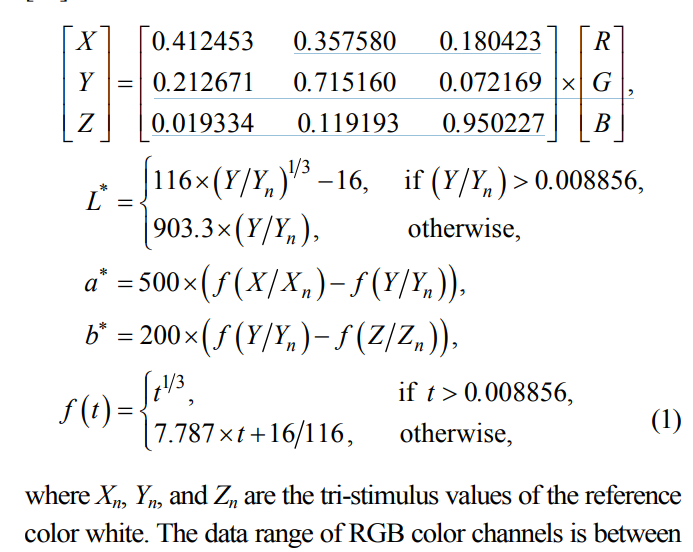

In [22]:
def f_lab(t):
    res = 0
    if t > 0.008856:
        res = t ** (1 / 3)
    else:
        7.787 * t + 16 / 116
    return res


def rgb_a_lab(r, g, b):
    matrix_lab = [
        [0.412453, 0.357580, 0.180423],
        [0.212671, 0.715160, 0.072169],
        [0.019334, 0.119193, 0.950227],
    ]
    rgb = [r, g, b]
    xyz = np.matmul(matrix_lab, rgb)
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    # tristimulus D65 std second obs
    # https://en.wikipedia.org/wiki/Standard_illuminant
    xn = 95.047
    yn = 100
    zn = 108.883
    a = 500 * (f_lab(x / xn) - f_lab(y / yn))
    b = 500 * (f_lab(y / yn) - f_lab(z / zn))
    l = 0
    if y / yn > 0.00856:
        l=116 * ((y / yn) ** 1 / 3) - 16
    else:
        l=903.3 * y / yn
    return (l, a, b)


def rgb_a_lab_img(img):
    h,w,_=img.shape
    img_lab=np.zeros((h,w,3))
    for i in range(h):
        for j in range(w):
            r,g,b=img[i,j]
            img_lab[i,j]=rgb_a_lab(r,g,b)
    return img_lab


# o usar img_lab = rgb2lab(img)

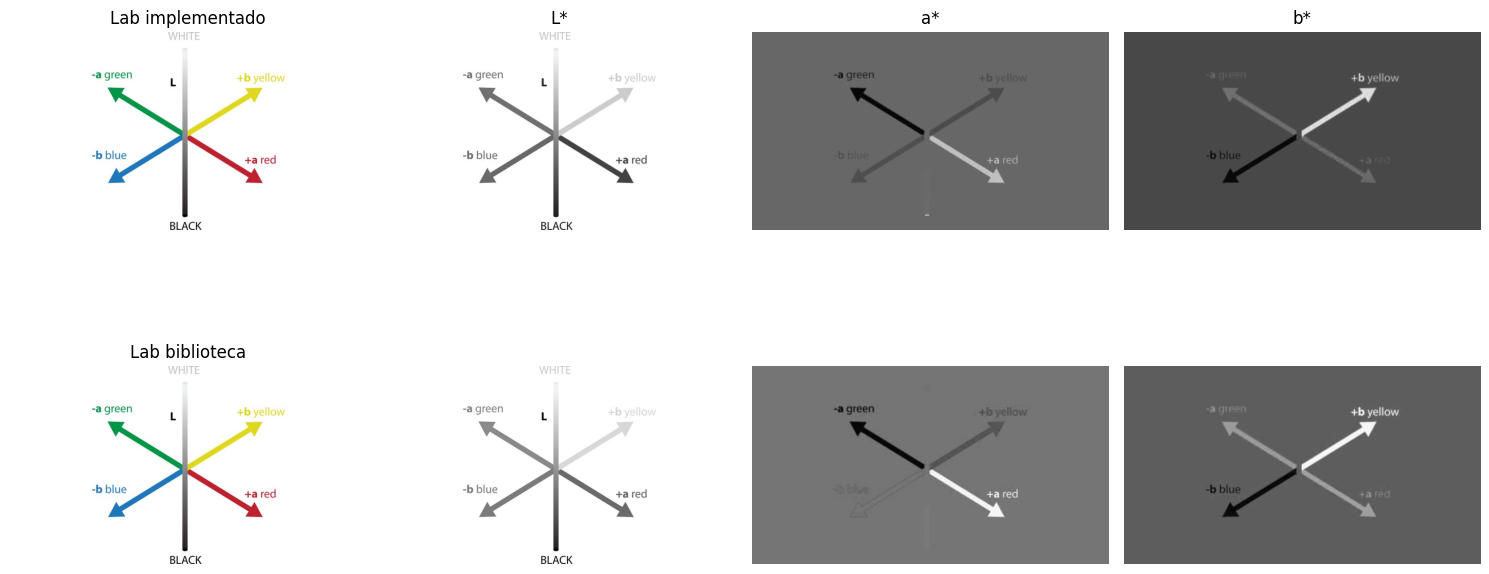

l:
-15.643163506666667
0.0
82.60000000000001
100.0
a:
-80.2362543898149
-55.196798633672664
117.62214821740268
65.42948252290526
b:
-111.85228688488824
-48.8416610590535
282.6105915533514
85.3811420334816


In [15]:
img = load_image("./images/img_teoria/CIELAB.jpg")

#img = io.imread("./images/CIELAB.jpg")

img_lab=rgb_a_lab_img(img)
img_lab_lib=rgb2lab(img)

l = img_lab[:, :, 0]
a = img_lab[:, :, 1]
b = img_lab[:, :, 2]

l_lib = img_lab_lib[:, :, 0]
a_lib = img_lab_lib[:, :, 1]
b_lib = img_lab_lib[:, :, 2]


fig, axes = plt.subplots(2, 4, figsize=(15, 8))
ax = axes.ravel()

ax[0].imshow(img)  # Imagen Compuesta
ax[1].imshow(l, cmap=plt.cm.gray)  # L*
ax[2].imshow(a, cmap=plt.cm.gray)  # a*
ax[3].imshow(b, cmap=plt.cm.gray)  # b*

ax[4].imshow(img)  # Imagen Compuesta
ax[5].imshow(l_lib, cmap=plt.cm.gray)  # L*
ax[6].imshow(a_lib, cmap=plt.cm.gray)  # a*
ax[7].imshow(b_lib, cmap=plt.cm.gray)  # b*


for t in ax:
    t.axis('off')

ax[0].set_title('Lab implementado')
ax[1].set_title('L*')
ax[2].set_title('a*')
ax[3].set_title('b*')
ax[4].set_title('Lab biblioteca')
fig.tight_layout()
plt.show()

####hay que arreglar rgb a lab..
print('l:')
print(np.min(l))
print(np.min(l_lib))
print(np.max(l))
print(np.max(l_lib))
print('a:')
print(np.min(a))
print(np.min(a_lib))
print(np.max(a))
print(np.max(a_lib))
print('b:')
print(np.min(b))
print(np.min(b_lib))
print(np.max(b))
print(np.max(b_lib))

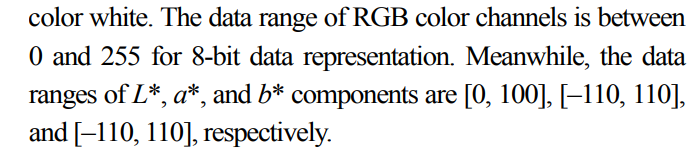

## Estadísticas Cie-lab

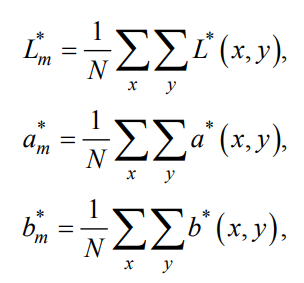

In [16]:
def statistical_ciel(img_lab):
    h, w, _ = img_lab.shape
    n = h * w
    ln = 0
    an = 0
    bn = 0
    for i in range(h):
        for j in range(w):
            ln += img_lab[i, j, 0]
            an += img_lab[i, j, 1]
            bn += img_lab[i, j, 2]

    ln = ln / n
    an = an / n
    bn = bn / n

    return (ln, an, bn)
    # o devolver
    # return (np.mean(img_lab[:,:,0]),np.mean(img_lab[:,:,1]),np.mean(img_lab[:,:,2]))
    # o quizás funciona
    # return np.mean(img, axis=2)

### R1, R2, R3, R4

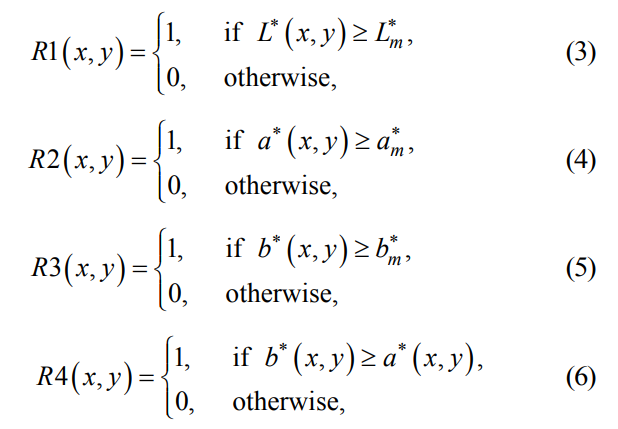

In [17]:
def binarizar(imag, thres, index):
    h, w, _ = imag.shape
    img_res = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            if imag[i, j, index] >= thres:
                img_res[i, j] = 1
    return img_res

def r1(img_lab, lm):
    return binarizar(img_lab, lm, 0)

def r2(img_lab, am):
    return binarizar(img_lab, am, 1)

def r3(img_lab, bm):
    return binarizar(img_lab, bm, 2)

def r4(img_lab):
    h, w, _ = img_lab.shape
    img_res = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            if img_lab[i, j, 2] >= img_lab[i, j, 1]:
                img_res[i, j] = 1
    return img_res

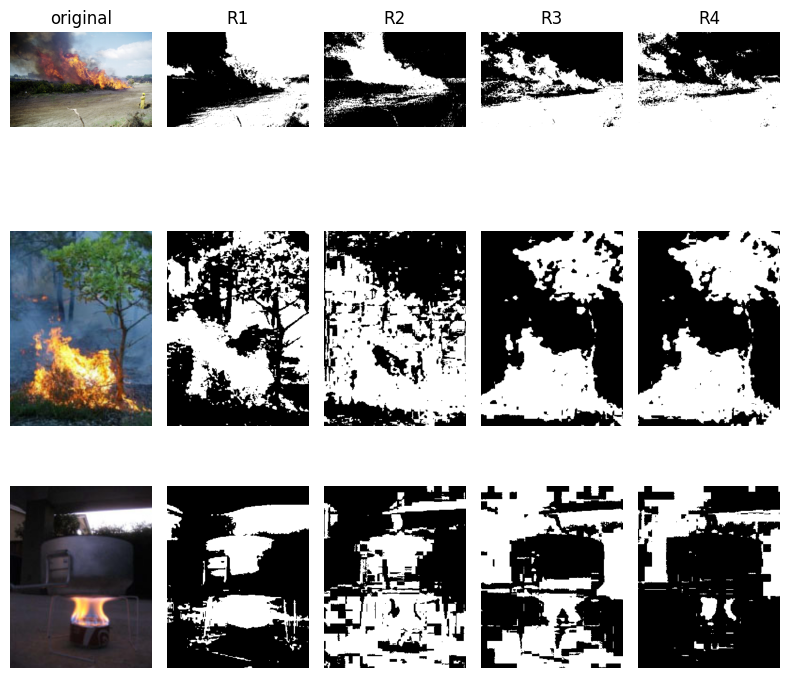

In [18]:
imagen_prueba = load_image("./images/sample2.jpg")
img_paper1 = load_image("./images/paper_img1.png")
img_paper2 = load_image("./images/paper_img2.png")

img_paper1=rgba2rgb(img_paper1)
img_paper2=rgba2rgb(img_paper2)
img_paper1=util.img_as_ubyte(img_paper1)
img_paper2=util.img_as_ubyte(img_paper2)

img_lab0 = rgb2lab(imagen_prueba)
img_lab1 = rgb_a_lab_img(img_paper1)
img_lab2 = rgb2lab(img_paper2)

lm, am, bm = statistical_ciel(img_lab0)
r1_img = r1(img_lab0, lm)
r2_img = r2(img_lab0, am)
r3_img = r3(img_lab0, bm)
r4_img = r4(img_lab0)

lm1, am1, bm1 = statistical_ciel(img_lab1)
r1_img1 = r1(img_lab1, lm1)
r2_img1 = r2(img_lab1, am1)
r3_img1 = r3(img_lab1, bm1)
r4_img1 = r4(img_lab1)

lm2, am2, bm2 = statistical_ciel(img_lab2)
r1_img2 = r1(img_lab2, lm2)
r2_img2 = r2(img_lab2, am2)
r3_img2 = r3(img_lab2, bm2)
r4_img2 = r4(img_lab2)

fig, axes = plt.subplots(3, 5, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(imagen_prueba)
ax[1].imshow(r1_img, cmap=plt.cm.gray)  # R1
ax[2].imshow(r2_img, cmap=plt.cm.gray)  # R2
ax[3].imshow(r3_img, cmap=plt.cm.gray)  # R3
ax[4].imshow(r4_img, cmap=plt.cm.gray)  # R4

ax[5].imshow(img_paper1)
ax[6].imshow(r1_img1, cmap=plt.cm.gray)  # R1
ax[7].imshow(r2_img1, cmap=plt.cm.gray)  # R2
ax[8].imshow(r3_img1, cmap=plt.cm.gray)  # R3
ax[9].imshow(r4_img1, cmap=plt.cm.gray)  # R4

ax[10].imshow(img_paper2)
ax[11].imshow(r1_img2, cmap=plt.cm.gray)  # R1
ax[12].imshow(r2_img2, cmap=plt.cm.gray)  # R2
ax[13].imshow(r3_img2, cmap=plt.cm.gray)  # R3
ax[14].imshow(r4_img2, cmap=plt.cm.gray)  # R4


for a in ax:
    a.axis('off')

ax[0].set_title('original')
ax[1].set_title('R1')
ax[2].set_title('R2')
ax[3].set_title('R3')
ax[4].set_title('R4')

fig.tight_layout()
plt.show()

In [24]:
def imprimir_rs_mask(imagen,r1,r2,r3,r4):
    and_img = np.logical_and(r1, r2)
    and_img = np.logical_and(and_img, r3)
    and_img = np.logical_and(and_img, r4)
    times_img=np.zeros_like(imagen)
    times_img[:,:,0]=and_img*imagen[:,:,0]
    times_img[:,:,1]=and_img*imagen[:,:,1]
    times_img[:,:,2]=and_img*imagen[:,:,2]

    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    ax = axes.ravel()
    ax[0].imshow(imagen)
    ax[0].axis('off')
    ax[1].imshow(and_img, cmap=plt.cm.gray)
    ax[1].axis('off')
    ax[2].imshow(times_img)
    ax[2].axis('off')

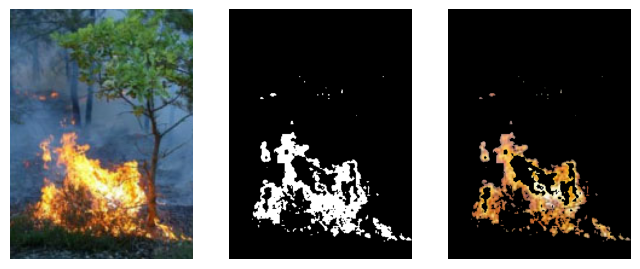

In [25]:
imprimir_rs_mask(img_paper1,r1_img1,r2_img1,r3_img1,r4_img1)

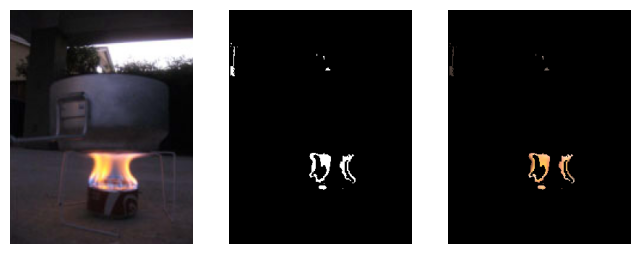

In [26]:
imprimir_rs_mask(img_paper2,r1_img2,r2_img2,r3_img2,r4_img2)

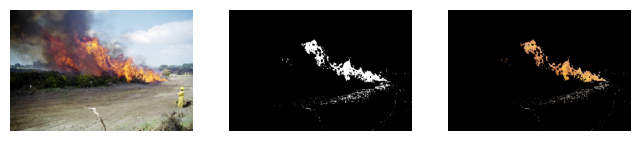

In [27]:
imprimir_rs_mask(imagen_prueba,r1_img,r2_img,r3_img,r4_img)

### Función de Verosimilitud

A histogram of fire pixels is created for each of the 3 different color planes, that is, (L*-a*), (L*-b*), and (a*-b*).

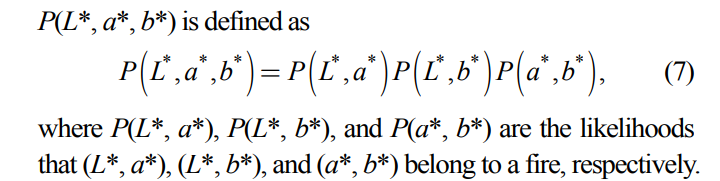

In [ ]:
def ps(vec_imgs,vec_masks):
  #histogramas
  p_ab=np.zeros((24,24))
  p_la=np.zeros((24,24))
  p_lb=np.zeros((24,24))
  cant=len(vec_imgs)
  pxs=0

  for k in range(0,cant):
    img=vec_imgs[k]
    mask=vec_masks[k]
    h,w,_=img.shape
    for i in range(h):
      for j in range(w):
        if mask[i,j]:
          #aumentar en 1 la,lb,ab
          l=img[i,j,0]
          a=img[i,j,1]
          b=img[i,j,2]
          l_ind=math.floor(24*l/101)
          a_ind=math.floor(24*(a+110)/221)
          b_ind=math.floor(24*(b+110)/221)
          p_la[l_ind,a_ind]+=1
          p_lb[l_ind,b_ind]+=1
          p_ab[a_ind,b_ind]+=1
          px+=1

  p_la=p_la/px
  p_lb=p_lb/px
  p_ab=p_ab/px

  return (p_la,p_lb,p_ab)



Obtenemos variables globales p1,p2,p3

In [29]:
#buscar data set segmentado y usarlo acá

vec=[]
masks=[]
#p1,p2,p3=ps(vec,masks)
p1=np.zeros((24,24))
p2=np.zeros((24,24))
p3=np.zeros((24,24))

p0=np.zeros((24,24))
p0[1:10,2:5]=1


printeamos p1,p2,p3

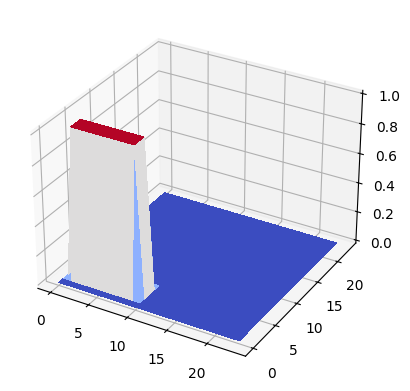

In [30]:
#documentación matplotlib
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0, 24, 1)
Y = np.arange(0, 24, 1)
X, Y = np.meshgrid(X, Y)
R = (X,Y)
Z = p0[R]

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
def p_lab(l,a,b):
    l_ind=math.floor(24*l/101)
    a_ind=math.floor(24*(a+110)/221)
    b_ind=math.floor(24*(b+110)/221)
    return p1(l_ind, a_ind) * p2(l_ind, b_ind) * p3(a_ind, b_ind)

### R5

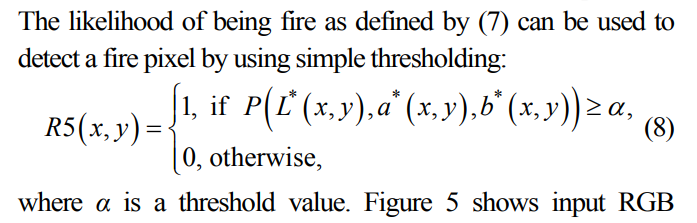

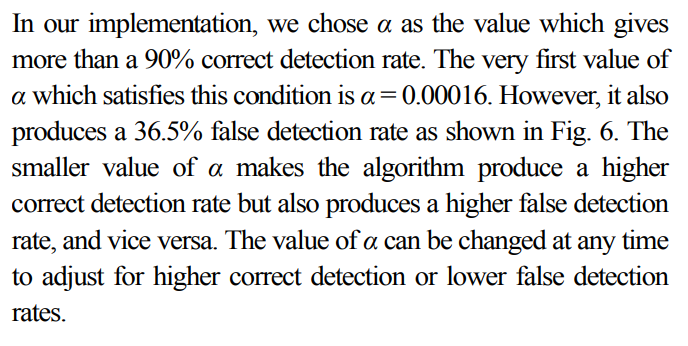

In [33]:
def r5(img_lab, alfa=0.00016):
    h, w, _ = img_lab.shape
    img_res = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            l = img_lab[i, j, 0]
            a = img_lab[i, j, 1]
            b = img_lab[i, j, 2]
            if p_lab(l, a, b) >= alfa:
                img_res[i, j] = 1

    return img_res

In [32]:
def final_rs(img_lab):
    h, w, _ = img_lab.shape
    ln, an, bn = statistical_ciel(img_lab)
    r_1 = r1(img_lab, ln)
    r_2 = r2(img_lab, an)
    r_3 = r3(img_lab, bn)
    r_4 = r4(img_lab)
    r_5 = r5(img_lab)

    img_res = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            if r_1[i, j] + r_2[i, j] + r_3[i, j] + r_4[i, j] + r_5[i, j] == 5:
                img_res[i, j] = 1

    return img_res

In [34]:
final_mask=final_rs(img_lab0)
times_img=np.zeros_like(imagen_prueba)
times_img[:,:,0]=final_mask*imagen_prueba[:,:,0]
times_img[:,:,1]=final_mask*imagen_prueba[:,:,1]
times_img[:,:,2]=final_mask*imagen_prueba[:,:,2]

fig, axes = plt.subplots(1, 3, figsize=(8, 8))
ax = axes.ravel()
ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(final_mask, cmap=plt.cm.gray)
ax[1].axis('off')
ax[2].imshow(times_img)
ax[2].axis('off')

NameError: name 'p_lab' is not defined

## Movimiento

There are three main parts in moving pixel detection: frame/background subtraction, background registration, and moving pixel detection.

### Media, Sigma y Tau

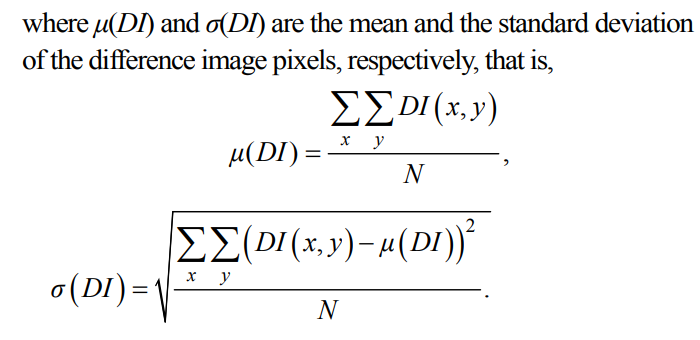

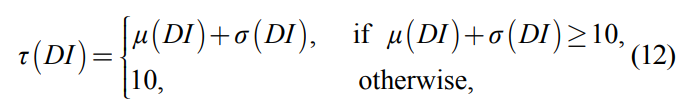

In [96]:
def mean_di(img_di):
    h, w = img_di.shape
    sum = 0
    n = h * w
    for i in range(h):
        for j in range(w):
            sum += img_di[i, j]

    return sum / n


def std_dev_di(img_di):
    mean = mean_di(img_di)
    h, w = img_di.shape
    sum = 0
    n = h * w
    for i in range(h):
        for j in range(w):
            sum += (img_di[i, j] - mean) ** 2

    return math.sqrt(sum / n)

In [115]:
# o versión fácil
def mean_di_np(img_di):
    return np.mean(img_di)


def std_dev_di_np(img_di):
    return np.std(img_di)

In [116]:
def tau(img_di):
    mean = mean_di_np(img_di)
    sigma = std_dev_di_np(img_di)
    if mean + sigma >= 10:
        res = mean + sigma
    else:
        res = 10
    return res

### Frame Difference

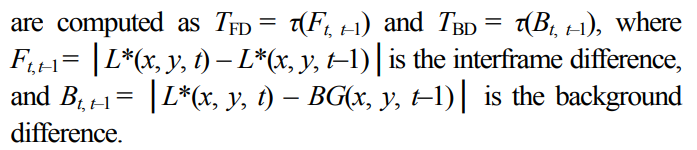

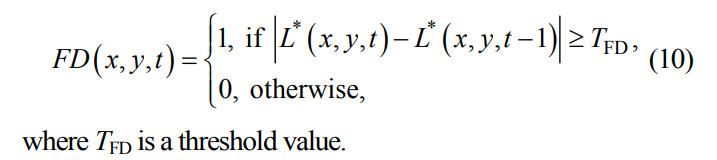

In [93]:
def frame_difference(img_lab_t, img_lab_t_ant, threshold_fd):
    h, w, _ = img_lab_t.shape
    img_fd = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            if abs(img_lab_t[i, j, 0] - img_lab_t_ant[i, j, 0]) >= threshold_fd:
                img_fd[i,j] = 1
    return img_fd


def frame_difference_dynamic_thres(img_lab_t, img_lab_t_ant):
    h, w, _ = img_lab_t.shape
    img_fd = np.zeros((h, w))
    dif_img = np.abs(img_lab_t[:, :, 0] - img_lab_t_ant[:, :, 0])
    thresh = tau(dif_img)
    for i in range(h):
        for j in range(w):
            dif = abs(
                img_lab_t[i, j, 0] - img_lab_t_ant[i, j, 0]
            )  # esto es dif_img[i,j] creo
            if dif >= thresh:
                img_fd[i,j] = 1
    return img_fd

In [166]:
# este devuelve todos los frame diff para todos los ts
def frame_differences_dynamic_thres(vec_imgs):
    cant, h, w, _ = vec_imgs.shape
    fds = np.zeros((cant, h, w))

    for k in range(1, cant):
        img_fd = np.zeros((h, w))
        img = vec_imgs[k]
        img_ant = vec_imgs[k - 1]
        dif_img = np.abs(img[:, :, 0] - img_ant[:, :, 0])
        thresh = tau(dif_img)
        for i in range(h):
            for j in range(w):
                #dif = abs(img[i, j, 0] - img_ant[i, j, 0])  # esto es dif_img[i,j] creo
                dif=dif_img[i,j]
                if dif >= thresh:
                    img_fd[i,j] = 1
        fds[k] = img_fd

    return fds

### Stationary Index

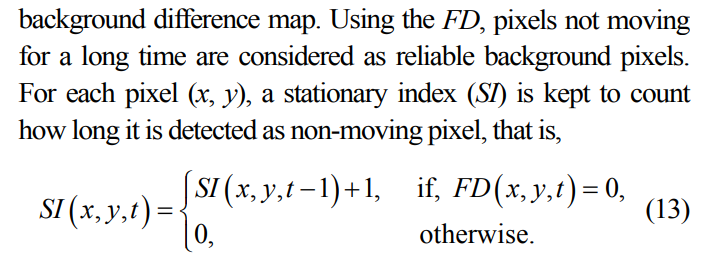

In [169]:
def stationary_index_v1(vec_imgs, k):
    cant = len(vec_imgs)
    img_0 = vec_imgs[0]
    h, w, _ = img_0.shape

    if k == 0:
        return np.zeros((h, w))
    else:
        si = np.zeros((h, w))
        fd = frame_difference_dynamic_thres(img[k], img[k + 1])
        si_ant = stationary_index_v1(vec_imgs, k - 1)
        for i in range(h):
            for j in range(w):
                if fd[i, j] == 0:
                    si[i, j] = si_ant[i, j] + 1

In [170]:
def stationary_indexes(vec_imgs):
    cant = len(vec_imgs)
    img_0 = vec_imgs[0]
    h, w, _ = img_0.shape
    sis = np.array(np.zeros((cant, h, w)))
    sis[0] = np.zeros((h, w))

    for k in range(1, cant - 1):
        fd = frame_difference_dynamic_thres(vec_imgs[k], vec_imgs[k - 1])
        si_ant = sis[k - 1]
        si = np.zeros((h, w))
        for i in range(h):
            for j in range(w):
                if fd[i, j] == 0:
                    si[i, j] = si_ant[i, j] + 1
        sis[k] = si

    return sis

### Background Difference

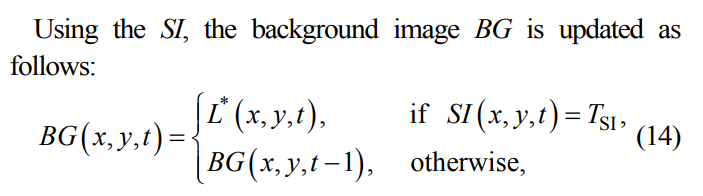

In [ ]:
def background_images(vec_imgs, thres_si):
    cant = len(vec_imgs)
    img_0 = vec_imgs[0]
    h, w, _ = img_0.shape
    sis = stationary_indexes(vec_imgs)
    bgs = np.zeros((k, h, w))
    bgs[0] = np.zeros((h, w))

    for k in range(1, cant - 1):
        img = vec_imgs[k]
        bg = bgs[k - 1]
        for i in range(h):
            for j in range(w):
                if sis[k, i, j] == thres_si:
                    l = img[i, j, 0]
                    bg[i, j] = l
        bgs[k] = bg
    return bgs

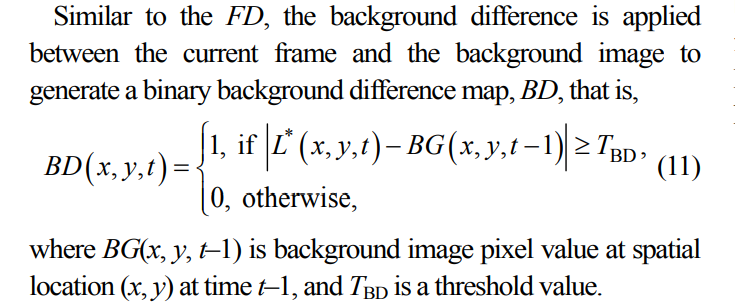

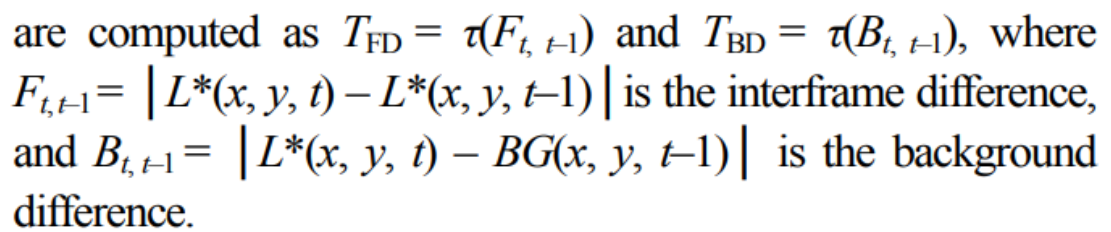

In [ ]:
def background_difference(vec_imgs):
    cant, h, w, _ = vec_imgs.shape
    bds = np.zeros((cant, h, w))
    bgs = background_images(vec_imgs, 10)

    for k in range(1, cant - 1):
        img = vec_imgs[k]
        bg_ant = bgs[k - 1]
        dif = np.abs(img[:, :, 0] - bg_ant)
        thresh = tau(dif)
        bd = np.zeros((h, w))
        for x in range(h):
            for y in range(w):
                if dif[x, y] >= thresh:
                    bd[x, y] = 1
        bds[k] = bd
    return bds

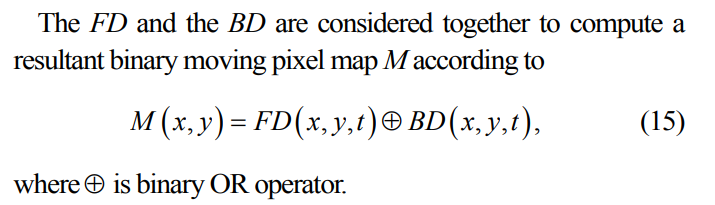

In [ ]:
def moving_pixel_map(vec_imgs):
    cant, h, w, _ = vec_imgs.shape
    bds = background_difference(vec_imgs)
    fds = frame_differences_dynamic_thres(vec_imgs)
    ms = np.zeros((cant, h, w))

    for k in range(cant):
        fd = fds[k]
        bd = bds[k]
        m = np.zeros((h, w))
        for i in range(h):
            for j in range(w):
                if fd[i, j] or bd[i, j]:
                    m[i, j] = 1
        ms[k] = m

    return ms

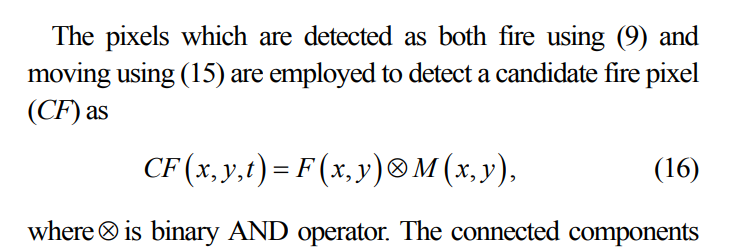

In [ ]:
def candidate_fire_pixels_vec(vec_imgs):
    cant, h, w, _ = vec_imgs.shape
    cfs = np.zeros((cant, h, w))
    ms = moving_pixel_map(vec_imgs)
    fs = np.zeros((cant, h, w))

    for k in range(cant):
        f = final_rs(vec_imgs[k])
        fs[k] = f

    for k in range(cant):
        cf = np.zeros((h, w))
        f = fs[k]
        m = ms[k]
        for i in range(h):
            for j in range(w):
                cf[i, j] = f[i, j] and m[i, j]
        cfs[k] = cf

    return cfs

In [ ]:
def en_rango(x,y,h,w):
  return 0<=x and x<h and 0<=y and y<w

def componentes_conexas(img_cf):
  h,w=img_cf.shape
  posiciones_con_uno=[]
  componentes_conexas=[] #O(t) lista de listas
  #cant_elementos_comp_conexas=[] #NO(t) lista de números
  indices_px_unos={}
  a_visitar=[]

  for x in range(h):
    for y in range(w):
      if img_cf[x,y]:
        posiciones_con_uno.append((x,y))
        indices_px_unos[(x,y)]=len(posiciones_con_uno)-1
  
  cant=len(posiciones_con_uno)
  componente_conexa_correspondiente=np.full(cant,-1)
      
  for k in range(cant):
    px,py=posiciones_con_uno[k]
    if componente_conexa_correspondiente[k]==-1:
      #crear componente conexa
      componentes_conexas.append([])
      n_cc=len(componentes_conexas)-1
      cant_cc=1
      a_visitar=[(px,py)]

      while len(a_visitar)!=0:
        cc_px,cc_py=a_visitar.pop()
        idx=indices_px_unos[(cc_px,cc_py)]

        componente_conexa_correspondiente[idx]=n_cc
        componentes_conexas[n_cc].append((vx,vy))
        cant_cc+=1

        #mirar vecinos y asignar componente conexa correspondiente
        for vx in range(max(cc_px-1,0),min(cc_px+2,h)):
          for vy in range(max(cc_py-1,0),min(cc_py+2,w)):
              if img_cf[cc_px,cc_py] and componente_conexa_correspondiente[idx]==-1:
                a_visitar.append((vx,vy))
        
      if(cant_cc==1):
        [(vx,vy)]=componentes_conexas.pop()
        idx=indices_px_unos[(vx,vy)]
        componente_conexa_correspondiente[vx,vy]=-1

  return componentes_conexas

In [ ]:
def componente_conexa_en_el_tiempo(img_cf,posiciones_con_uno,indices_px_unos,componente):
  h,w=img_cf.shape
  componente_act=[]

  visitados=np.zeros_like(posiciones_con_uno)
  a_visitar=[]

  for i in range(len(componente)):
    px=componente[i]
    idx=indices_px_unos[px]
    if img_cf[px]==1:
      a_visitar.append(px)
      visitados[px]=1
  
  while len(a_visitar)!=0:
    cc_px,cc_py=a_visitar.pop()    
    componente_act.append((vx,vy))
    idx=indices_px_unos[(vx,vy)]
    visitados[idx]=1
    #mirar vecinos y asignar componente conexa correspondiente
    for vx in range(max(cc_px-1,0),min(cc_px+2,h)):
      for vy in range(max(cc_py-1,0),min(cc_py+2,w)):
        if img_cf[vx,vy] and not visitados[idx]:
          a_visitar.append((vx,vy))
  
  return componente_act

In [ ]:
def posiciones_indices_con_uno_img(img_cf):
    h,w=img_cf.shape
    posiciones_con_uno=[]
    indices_px_unos={}
    for x in range(h):
        for y in range(w):
            if img_cf[x,y]:
                posiciones_con_uno.append((x,y))
                indices_px_unos[(x,y)]=len(posiciones_con_uno)-1
    
    return (indices_px_unos,posiciones_con_uno)

def posiciones_indices_con_uno_video(img_cfs):
    cant,_,_=img_cfs.shape
    video_posiciones_con_uno=[]
    video_indices_px_unos=[]

    for k in range(cant):
        img_cf=img_cfs[k]
        indices_px_unos,posiciones_con_uno=posiciones_indices_con_uno_img(img_cf)
        video_posiciones_con_uno.append(posiciones_con_uno)
        video_indices_px_unos.append(indices_px_unos)

    return (video_indices_px_unos,video_posiciones_con_uno)

def cgo(vec_video):
    
    cant_v=len(vec_video)
    cant_cc=len(componentes_conexas)
    cgos=np.zeros((cant_v,cant_cc)) #contador de movimiento por componente conexa
    n_elem_comp=np.zeros((cant_v,cant_cc))
    cfs=candidate_fire_pixels_vec(vec_video)

    componentes_conexas=componentes_conexas(cfs[0])
    video_indices_px_unos,video_posiciones_con_uno=posiciones_indices_con_uno_video(vec_video)

    for comp_ind in range(cant_cc):
        comp_act=componentes_conexas[comp_ind]
        n_elem_comp[k,comp_ind]=len(comp_act)

    #componentes_conexas es lista de: lista de posiciones [c1,c2....,cn] -> ci -> [px1....pxm]
    for comp_ind in range(cant_cc):
        comp_act=componentes_conexas[comp_ind]
        for k in range(1,cant_v):
            img_cf=cfs[k]
            comp_act=componente_conexa_en_el_tiempo(img_cf,video_posiciones_con_uno[k],video_indices_px_unos[k],comp_act)
            n_elem_comp[k,comp_ind]=len(comp_act)

    for comp_ind in range(cant_cc):
        for k in range(1,cant_v):
            if n_elem_comp[k,comp_ind]>=n_elem_comp[k-1,comp_ind]:
                cgos[k,comp_ind]=cgos[k-1,comp_ind]+1
            else:
                cgos[k,comp_ind]=cgos[k-1,comp_ind]
    
    return cgos

In [ ]:
def d_metric(cgo,cgo_1s_ant,fps):
    return (cgo-cgo_1s_ant)/fps

In [ ]:
def main():
    pass

True
708


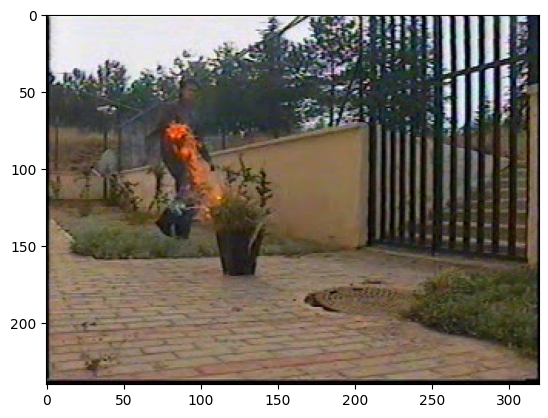

In [137]:
vc_device=cv2.VideoCapture("./images/videos/fire1.avi")
print(vc_device.isOpened())
hay_frame,imagen_frame_prueba=vc_device.read()
video_fire1=[]

while hay_frame:
    img_rgb=cv2.cvtColor(imagen_frame_prueba, cv2.COLOR_BGR2RGB)
    video_fire1.append(img_rgb.astype(np.int32))
    hay_frame,imagen_frame_prueba=vc_device.read()

print(len(video_fire1))
plt.imshow(video_fire1[200])


c:\Users\Juan\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\util\dtype.py:576: UserWarning: Downcasting int32 to uint8 without scaling because max value 255 fits in uint8
  return _convert(image, np.uint8, force_copy)


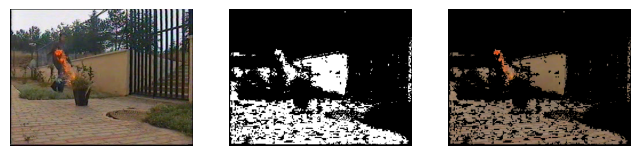

In [139]:
frame_200_fire1=video_fire1[200]
frame_200_fire1=util.img_as_ubyte(frame_200_fire1)
frame_200_lab=rgb2lab(frame_200_fire1)
lm_0,am_0,bm_0=statistical_ciel(frame_200_lab)
r1_0=r1(frame_200_lab,lm_0)
r2_0=r2(frame_200_lab,am_0)
r3_0=r3(frame_200_lab,bm_0)
r4_0=r4(frame_200_lab)

imprimir_rs_mask(frame_200_fire1,r1_0,r2_0,r3_0,r4_0)

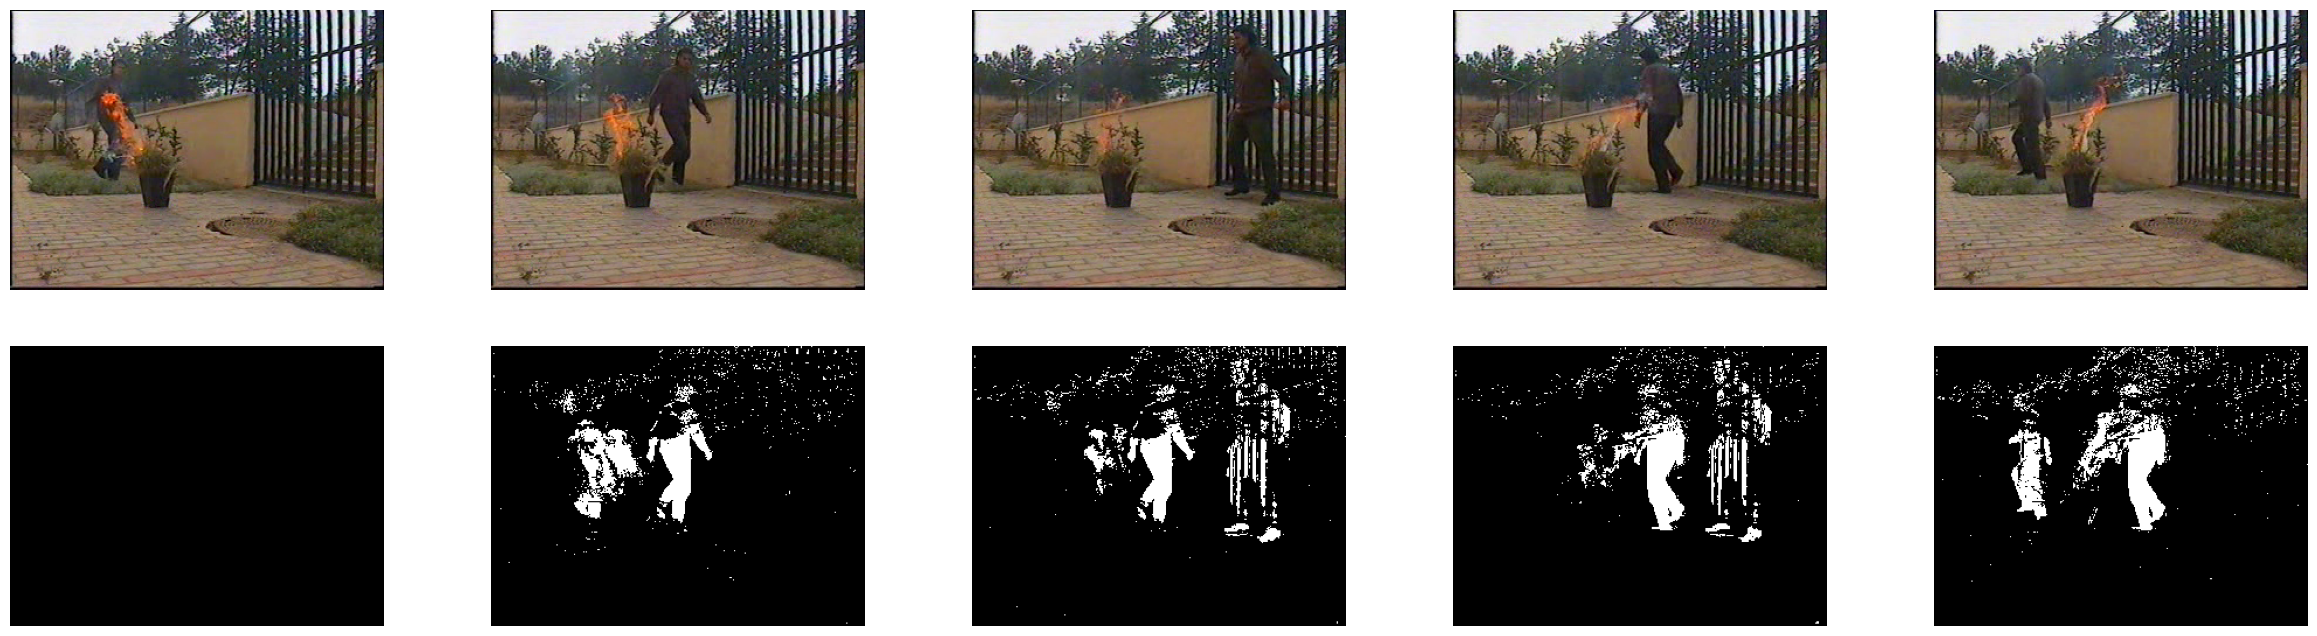

In [167]:
video_fire1_cada_10=video_fire1[200:300:20]
fds=frame_differences_dynamic_thres(np.array(video_fire1_cada_10))
fig, axes = plt.subplots(2, 5, figsize=(30, 8))
ax = axes.ravel()

for ax0 in ax:
    ax0.axis('off')

for i in range(5):
    axes[0][i].imshow(video_fire1_cada_10[i])
    axes[1][i].imshow(fds[i],cmap='gray')


In [168]:
video_fire1_ejemplo=video_fire1[200:210:1]
sis_ej=stationary_indexes(video_fire1_ejemplo)

fig, axes = plt.subplots(2, 5, figsize=(30, 8))
ax = axes.ravel()
for ax0 in ax:
    ax0.axis('off')

for i in range(5):
    axes[0][i].imshow(video_fire1_ejemplo[i])
    axes[1][i].imshow(sis_ej[i],cmap='gray')


NameError: name 'stationary_indexes' is not defined

#####chequar resta truncada antes de abs